# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tf/lib/python3.5/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tf/lib/python3.5/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


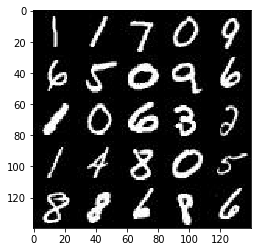

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline

import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

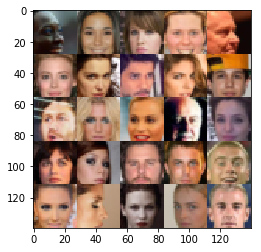

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name='real_input')
    z_input = tf.placeholder(tf.float32, [None,z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
## included alpha parameter to implement leaky relu like in the dcgan-svhn notebook
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
## included alpha parameter to implement leaky relu like in the dcgan-svhn notebook
## reuse set to true if not in training
## included keep probabilty parameter 
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.9):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse=not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 3*3*512)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
                
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
# added included parameter
# added smoothing parameter
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
#included alpha parameter
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
       
    losses = []
    steps = 0
    print_every=10
    show_every=100
    n_images = 9

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = 2*batch_images
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, channels, data_image_mode)
              

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 0.5013... Generator Loss: 1.1783
Epoch 1/2... Discriminator Loss: 0.2938... Generator Loss: 1.8142
Epoch 1/2... Discriminator Loss: 0.2528... Generator Loss: 1.8644
Epoch 1/2... Discriminator Loss: 0.2941... Generator Loss: 1.8975
Epoch 1/2... Discriminator Loss: 0.2307... Generator Loss: 1.9812
Epoch 1/2... Discriminator Loss: 0.2054... Generator Loss: 2.0772
Epoch 1/2... Discriminator Loss: 0.2049... Generator Loss: 2.1204
Epoch 1/2... Discriminator Loss: 0.2373... Generator Loss: 2.0449
Epoch 1/2... Discriminator Loss: 0.3583... Generator Loss: 1.7745


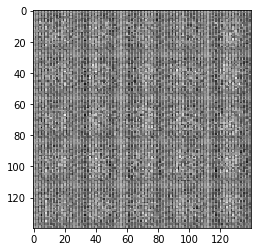

Epoch 1/2... Discriminator Loss: 0.3451... Generator Loss: 1.8456
Epoch 1/2... Discriminator Loss: 0.3805... Generator Loss: 1.8415
Epoch 1/2... Discriminator Loss: 0.3594... Generator Loss: 1.7464
Epoch 1/2... Discriminator Loss: 0.4694... Generator Loss: 1.6228
Epoch 1/2... Discriminator Loss: 0.4403... Generator Loss: 1.5691
Epoch 1/2... Discriminator Loss: 0.6704... Generator Loss: 1.2891
Epoch 1/2... Discriminator Loss: 0.4177... Generator Loss: 1.6512
Epoch 1/2... Discriminator Loss: 0.5403... Generator Loss: 1.4540
Epoch 1/2... Discriminator Loss: 0.4565... Generator Loss: 1.4994
Epoch 1/2... Discriminator Loss: 0.4014... Generator Loss: 1.7640


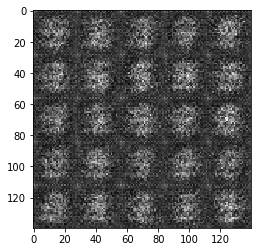

Epoch 1/2... Discriminator Loss: 0.3406... Generator Loss: 1.7964
Epoch 1/2... Discriminator Loss: 0.3758... Generator Loss: 1.9646
Epoch 1/2... Discriminator Loss: 0.2917... Generator Loss: 2.2180
Epoch 1/2... Discriminator Loss: 0.2049... Generator Loss: 2.5287
Epoch 1/2... Discriminator Loss: 0.2067... Generator Loss: 2.3037
Epoch 1/2... Discriminator Loss: 0.1788... Generator Loss: 2.6263
Epoch 1/2... Discriminator Loss: 0.1848... Generator Loss: 2.4762
Epoch 1/2... Discriminator Loss: 0.2200... Generator Loss: 2.5319
Epoch 1/2... Discriminator Loss: 0.1979... Generator Loss: 2.3679
Epoch 1/2... Discriminator Loss: 0.1561... Generator Loss: 2.6075


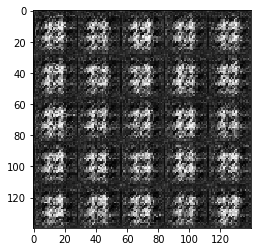

Epoch 1/2... Discriminator Loss: 0.0993... Generator Loss: 3.2192
Epoch 1/2... Discriminator Loss: 0.0898... Generator Loss: 3.2833
Epoch 1/2... Discriminator Loss: 0.1921... Generator Loss: 2.4981
Epoch 1/2... Discriminator Loss: 0.1279... Generator Loss: 2.9967
Epoch 1/2... Discriminator Loss: 0.1070... Generator Loss: 3.0590
Epoch 1/2... Discriminator Loss: 0.1014... Generator Loss: 3.0733
Epoch 1/2... Discriminator Loss: 0.1910... Generator Loss: 2.6594
Epoch 1/2... Discriminator Loss: 0.1871... Generator Loss: 2.6723
Epoch 1/2... Discriminator Loss: 0.1666... Generator Loss: 2.5486
Epoch 1/2... Discriminator Loss: 0.1702... Generator Loss: 2.6925


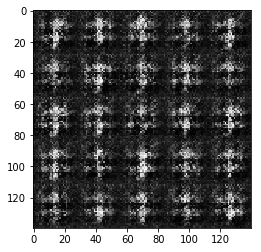

Epoch 1/2... Discriminator Loss: 0.1789... Generator Loss: 2.8048
Epoch 1/2... Discriminator Loss: 0.0914... Generator Loss: 3.2225
Epoch 1/2... Discriminator Loss: 0.0897... Generator Loss: 3.5285
Epoch 1/2... Discriminator Loss: 0.1883... Generator Loss: 3.6678
Epoch 1/2... Discriminator Loss: 0.2361... Generator Loss: 3.1141
Epoch 1/2... Discriminator Loss: 0.1831... Generator Loss: 2.8931
Epoch 1/2... Discriminator Loss: 0.1432... Generator Loss: 3.2512
Epoch 1/2... Discriminator Loss: 0.1888... Generator Loss: 2.9402
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 1.6556
Epoch 1/2... Discriminator Loss: 0.3237... Generator Loss: 2.2780


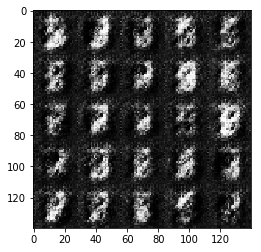

Epoch 1/2... Discriminator Loss: 0.1941... Generator Loss: 3.2048
Epoch 1/2... Discriminator Loss: 0.1999... Generator Loss: 2.7532
Epoch 1/2... Discriminator Loss: 0.2670... Generator Loss: 2.3383
Epoch 1/2... Discriminator Loss: 0.2523... Generator Loss: 2.6283
Epoch 1/2... Discriminator Loss: 0.2452... Generator Loss: 2.4586
Epoch 1/2... Discriminator Loss: 0.3188... Generator Loss: 2.4266
Epoch 1/2... Discriminator Loss: 0.2275... Generator Loss: 2.7825
Epoch 1/2... Discriminator Loss: 0.2491... Generator Loss: 2.3956
Epoch 1/2... Discriminator Loss: 0.2726... Generator Loss: 2.4396
Epoch 1/2... Discriminator Loss: 0.2865... Generator Loss: 2.4391


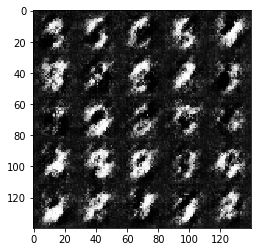

Epoch 1/2... Discriminator Loss: 0.3743... Generator Loss: 2.3561
Epoch 1/2... Discriminator Loss: 0.1521... Generator Loss: 2.8113
Epoch 1/2... Discriminator Loss: 0.3009... Generator Loss: 2.1454
Epoch 1/2... Discriminator Loss: 0.2415... Generator Loss: 2.6193
Epoch 1/2... Discriminator Loss: 0.3275... Generator Loss: 2.0587
Epoch 1/2... Discriminator Loss: 0.2285... Generator Loss: 2.5247
Epoch 1/2... Discriminator Loss: 0.1864... Generator Loss: 2.6833
Epoch 1/2... Discriminator Loss: 0.2535... Generator Loss: 2.2657
Epoch 1/2... Discriminator Loss: 0.2552... Generator Loss: 2.2306
Epoch 1/2... Discriminator Loss: 0.2282... Generator Loss: 2.7907


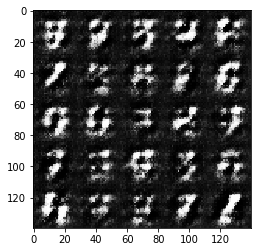

Epoch 1/2... Discriminator Loss: 0.2392... Generator Loss: 2.4562
Epoch 1/2... Discriminator Loss: 0.3356... Generator Loss: 2.0703
Epoch 1/2... Discriminator Loss: 0.3407... Generator Loss: 2.7039
Epoch 1/2... Discriminator Loss: 0.2997... Generator Loss: 2.2100
Epoch 1/2... Discriminator Loss: 0.2068... Generator Loss: 2.6478
Epoch 1/2... Discriminator Loss: 0.2722... Generator Loss: 2.1627
Epoch 1/2... Discriminator Loss: 0.4536... Generator Loss: 1.8276
Epoch 1/2... Discriminator Loss: 0.2456... Generator Loss: 2.5009
Epoch 1/2... Discriminator Loss: 0.3102... Generator Loss: 1.9278
Epoch 1/2... Discriminator Loss: 0.3673... Generator Loss: 2.4558


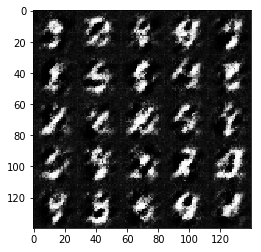

Epoch 1/2... Discriminator Loss: 0.3257... Generator Loss: 2.5229
Epoch 1/2... Discriminator Loss: 0.4078... Generator Loss: 2.3658
Epoch 1/2... Discriminator Loss: 0.3149... Generator Loss: 1.9507
Epoch 1/2... Discriminator Loss: 0.2396... Generator Loss: 2.6936
Epoch 1/2... Discriminator Loss: 0.5150... Generator Loss: 1.3096
Epoch 1/2... Discriminator Loss: 0.2152... Generator Loss: 2.8250
Epoch 1/2... Discriminator Loss: 0.2921... Generator Loss: 2.2406
Epoch 1/2... Discriminator Loss: 0.3863... Generator Loss: 2.1155
Epoch 1/2... Discriminator Loss: 0.2098... Generator Loss: 2.8069
Epoch 1/2... Discriminator Loss: 0.2290... Generator Loss: 2.4733


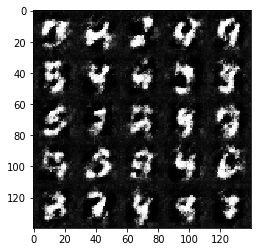

Epoch 1/2... Discriminator Loss: 0.3257... Generator Loss: 1.9532
Epoch 1/2... Discriminator Loss: 0.2991... Generator Loss: 1.9132
Epoch 1/2... Discriminator Loss: 0.2790... Generator Loss: 2.5204
Epoch 1/2... Discriminator Loss: 0.2870... Generator Loss: 2.7776
Epoch 1/2... Discriminator Loss: 0.2902... Generator Loss: 2.5837
Epoch 1/2... Discriminator Loss: 0.2488... Generator Loss: 2.6027
Epoch 1/2... Discriminator Loss: 0.4078... Generator Loss: 1.4300
Epoch 1/2... Discriminator Loss: 0.3756... Generator Loss: 1.6281
Epoch 1/2... Discriminator Loss: 0.3970... Generator Loss: 1.9394
Epoch 1/2... Discriminator Loss: 0.3417... Generator Loss: 2.0904


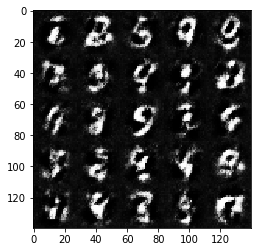

Epoch 1/2... Discriminator Loss: 0.3615... Generator Loss: 2.4465
Epoch 1/2... Discriminator Loss: 0.3658... Generator Loss: 2.1459
Epoch 1/2... Discriminator Loss: 0.2767... Generator Loss: 2.4481
Epoch 1/2... Discriminator Loss: 0.2329... Generator Loss: 2.5513
Epoch 1/2... Discriminator Loss: 0.4410... Generator Loss: 1.8852
Epoch 1/2... Discriminator Loss: 0.3098... Generator Loss: 2.2132
Epoch 1/2... Discriminator Loss: 0.3502... Generator Loss: 1.9409
Epoch 1/2... Discriminator Loss: 0.3165... Generator Loss: 2.3948
Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 2.8134
Epoch 1/2... Discriminator Loss: 0.3463... Generator Loss: 1.8843


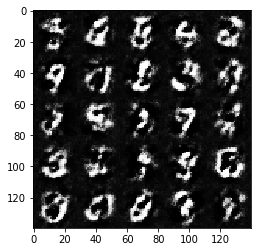

Epoch 1/2... Discriminator Loss: 0.3577... Generator Loss: 2.0219
Epoch 1/2... Discriminator Loss: 0.3306... Generator Loss: 1.8833
Epoch 1/2... Discriminator Loss: 0.2806... Generator Loss: 2.1864
Epoch 1/2... Discriminator Loss: 0.3837... Generator Loss: 1.5502
Epoch 1/2... Discriminator Loss: 0.3265... Generator Loss: 2.1530
Epoch 1/2... Discriminator Loss: 0.3422... Generator Loss: 2.3174
Epoch 1/2... Discriminator Loss: 0.2956... Generator Loss: 2.5547
Epoch 1/2... Discriminator Loss: 0.4569... Generator Loss: 1.2375
Epoch 1/2... Discriminator Loss: 0.2754... Generator Loss: 2.6336
Epoch 1/2... Discriminator Loss: 0.2903... Generator Loss: 2.0944


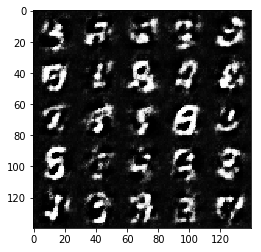

Epoch 1/2... Discriminator Loss: 0.3701... Generator Loss: 1.6128
Epoch 1/2... Discriminator Loss: 0.2726... Generator Loss: 2.4691
Epoch 1/2... Discriminator Loss: 0.2804... Generator Loss: 2.3383
Epoch 1/2... Discriminator Loss: 0.3254... Generator Loss: 2.0433
Epoch 1/2... Discriminator Loss: 0.2136... Generator Loss: 2.5950
Epoch 1/2... Discriminator Loss: 0.2483... Generator Loss: 2.3717
Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 3.4551
Epoch 1/2... Discriminator Loss: 0.3680... Generator Loss: 3.0628
Epoch 1/2... Discriminator Loss: 0.2691... Generator Loss: 2.3018
Epoch 1/2... Discriminator Loss: 0.2294... Generator Loss: 2.3396


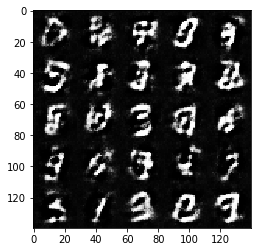

Epoch 1/2... Discriminator Loss: 0.3784... Generator Loss: 1.6239
Epoch 1/2... Discriminator Loss: 0.3307... Generator Loss: 2.2967
Epoch 1/2... Discriminator Loss: 0.2670... Generator Loss: 2.2934
Epoch 1/2... Discriminator Loss: 0.2764... Generator Loss: 2.8407
Epoch 1/2... Discriminator Loss: 0.5983... Generator Loss: 4.2039
Epoch 1/2... Discriminator Loss: 0.2815... Generator Loss: 2.3850
Epoch 1/2... Discriminator Loss: 0.4862... Generator Loss: 2.0110
Epoch 1/2... Discriminator Loss: 0.4290... Generator Loss: 1.5404
Epoch 1/2... Discriminator Loss: 0.4274... Generator Loss: 1.5622
Epoch 1/2... Discriminator Loss: 0.2605... Generator Loss: 2.0231


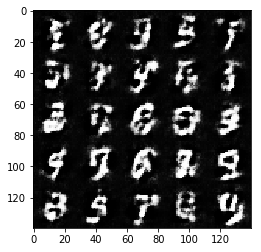

Epoch 1/2... Discriminator Loss: 0.2600... Generator Loss: 2.2432
Epoch 1/2... Discriminator Loss: 0.3947... Generator Loss: 1.5747
Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 1.8872
Epoch 1/2... Discriminator Loss: 0.4648... Generator Loss: 1.3779
Epoch 1/2... Discriminator Loss: 0.2399... Generator Loss: 2.5009
Epoch 1/2... Discriminator Loss: 0.3401... Generator Loss: 1.9125
Epoch 1/2... Discriminator Loss: 0.3797... Generator Loss: 1.8291
Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 2.2191
Epoch 1/2... Discriminator Loss: 0.2917... Generator Loss: 2.3011
Epoch 1/2... Discriminator Loss: 0.2961... Generator Loss: 3.0400


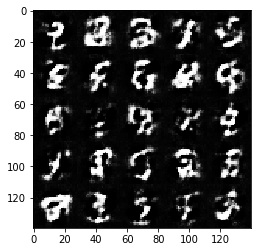

Epoch 1/2... Discriminator Loss: 0.2877... Generator Loss: 2.5143
Epoch 1/2... Discriminator Loss: 0.1995... Generator Loss: 2.8557
Epoch 1/2... Discriminator Loss: 0.2592... Generator Loss: 2.4011
Epoch 1/2... Discriminator Loss: 0.3043... Generator Loss: 2.4484
Epoch 1/2... Discriminator Loss: 0.3034... Generator Loss: 2.1398
Epoch 1/2... Discriminator Loss: 0.2676... Generator Loss: 2.0960
Epoch 1/2... Discriminator Loss: 0.3738... Generator Loss: 1.9355
Epoch 1/2... Discriminator Loss: 0.2717... Generator Loss: 2.1656
Epoch 1/2... Discriminator Loss: 0.2341... Generator Loss: 1.9796
Epoch 1/2... Discriminator Loss: 0.2619... Generator Loss: 2.3016


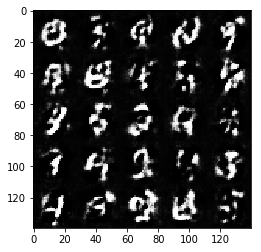

Epoch 1/2... Discriminator Loss: 0.2235... Generator Loss: 2.4001
Epoch 1/2... Discriminator Loss: 0.3279... Generator Loss: 2.0355
Epoch 1/2... Discriminator Loss: 0.4068... Generator Loss: 1.5693
Epoch 1/2... Discriminator Loss: 0.3031... Generator Loss: 2.5084
Epoch 1/2... Discriminator Loss: 0.3075... Generator Loss: 2.0119
Epoch 1/2... Discriminator Loss: 0.3011... Generator Loss: 1.9783
Epoch 1/2... Discriminator Loss: 0.2585... Generator Loss: 2.0295
Epoch 1/2... Discriminator Loss: 0.3457... Generator Loss: 2.3485
Epoch 1/2... Discriminator Loss: 0.2522... Generator Loss: 1.8355
Epoch 1/2... Discriminator Loss: 0.2678... Generator Loss: 1.9006


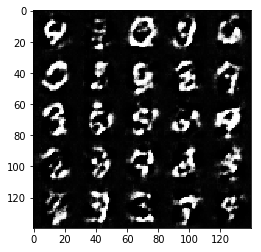

Epoch 1/2... Discriminator Loss: 0.2651... Generator Loss: 2.3284
Epoch 1/2... Discriminator Loss: 0.2665... Generator Loss: 2.2998
Epoch 1/2... Discriminator Loss: 0.2408... Generator Loss: 2.4769
Epoch 1/2... Discriminator Loss: 0.2040... Generator Loss: 2.4216
Epoch 1/2... Discriminator Loss: 0.2292... Generator Loss: 2.4554
Epoch 1/2... Discriminator Loss: 0.2603... Generator Loss: 2.3938
Epoch 1/2... Discriminator Loss: 0.4314... Generator Loss: 1.7393
Epoch 1/2... Discriminator Loss: 0.2115... Generator Loss: 2.6228
Epoch 1/2... Discriminator Loss: 0.2083... Generator Loss: 3.1221
Epoch 1/2... Discriminator Loss: 0.2776... Generator Loss: 1.8663


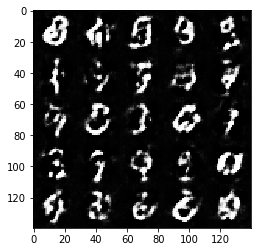

Epoch 1/2... Discriminator Loss: 0.2502... Generator Loss: 2.5783
Epoch 1/2... Discriminator Loss: 0.3336... Generator Loss: 2.1962
Epoch 1/2... Discriminator Loss: 0.3568... Generator Loss: 2.1736
Epoch 1/2... Discriminator Loss: 0.2744... Generator Loss: 2.2992
Epoch 1/2... Discriminator Loss: 0.3511... Generator Loss: 1.9384
Epoch 1/2... Discriminator Loss: 0.2420... Generator Loss: 2.5758
Epoch 1/2... Discriminator Loss: 0.2860... Generator Loss: 2.1897
Epoch 2/2... Discriminator Loss: 0.2799... Generator Loss: 2.2334
Epoch 2/2... Discriminator Loss: 0.2918... Generator Loss: 2.5592
Epoch 2/2... Discriminator Loss: 0.2953... Generator Loss: 2.1757


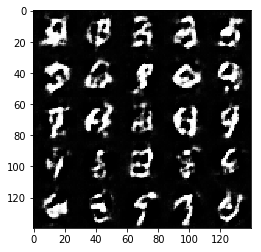

Epoch 2/2... Discriminator Loss: 0.3385... Generator Loss: 1.8065
Epoch 2/2... Discriminator Loss: 0.2499... Generator Loss: 2.0898
Epoch 2/2... Discriminator Loss: 0.2905... Generator Loss: 2.0367
Epoch 2/2... Discriminator Loss: 0.2762... Generator Loss: 1.9370
Epoch 2/2... Discriminator Loss: 0.2283... Generator Loss: 2.5932
Epoch 2/2... Discriminator Loss: 0.2776... Generator Loss: 2.4277
Epoch 2/2... Discriminator Loss: 0.3113... Generator Loss: 1.9384
Epoch 2/2... Discriminator Loss: 0.2393... Generator Loss: 2.9077
Epoch 2/2... Discriminator Loss: 0.2569... Generator Loss: 2.2459
Epoch 2/2... Discriminator Loss: 0.2686... Generator Loss: 2.3398


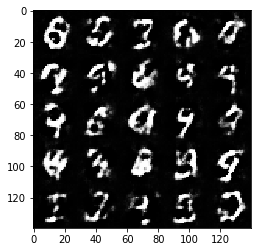

Epoch 2/2... Discriminator Loss: 0.3202... Generator Loss: 1.8729
Epoch 2/2... Discriminator Loss: 0.1705... Generator Loss: 2.7325
Epoch 2/2... Discriminator Loss: 0.2553... Generator Loss: 1.9872
Epoch 2/2... Discriminator Loss: 0.3061... Generator Loss: 1.8504
Epoch 2/2... Discriminator Loss: 0.2260... Generator Loss: 2.4551
Epoch 2/2... Discriminator Loss: 0.2688... Generator Loss: 2.3105
Epoch 2/2... Discriminator Loss: 0.3545... Generator Loss: 1.5971
Epoch 2/2... Discriminator Loss: 0.2248... Generator Loss: 3.0213
Epoch 2/2... Discriminator Loss: 0.2853... Generator Loss: 2.4820
Epoch 2/2... Discriminator Loss: 0.1675... Generator Loss: 2.9472


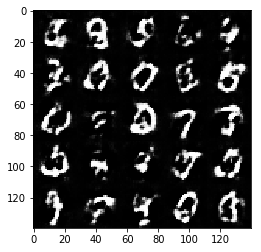

Epoch 2/2... Discriminator Loss: 0.5531... Generator Loss: 1.1718
Epoch 2/2... Discriminator Loss: 0.2531... Generator Loss: 2.0237
Epoch 2/2... Discriminator Loss: 0.2477... Generator Loss: 2.4472
Epoch 2/2... Discriminator Loss: 0.3676... Generator Loss: 2.7943
Epoch 2/2... Discriminator Loss: 0.1638... Generator Loss: 3.2548
Epoch 2/2... Discriminator Loss: 0.2251... Generator Loss: 2.2337
Epoch 2/2... Discriminator Loss: 0.4037... Generator Loss: 1.4611
Epoch 2/2... Discriminator Loss: 0.1260... Generator Loss: 3.0677
Epoch 2/2... Discriminator Loss: 0.2278... Generator Loss: 2.9138
Epoch 2/2... Discriminator Loss: 0.1795... Generator Loss: 2.8468


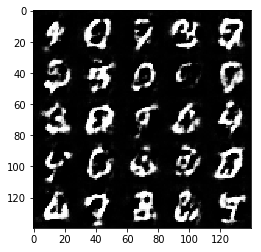

Epoch 2/2... Discriminator Loss: 0.1948... Generator Loss: 3.1437
Epoch 2/2... Discriminator Loss: 0.3829... Generator Loss: 1.6419
Epoch 2/2... Discriminator Loss: 0.2478... Generator Loss: 2.7207
Epoch 2/2... Discriminator Loss: 0.4330... Generator Loss: 1.6139
Epoch 2/2... Discriminator Loss: 0.2861... Generator Loss: 2.4446
Epoch 2/2... Discriminator Loss: 0.3420... Generator Loss: 1.7740
Epoch 2/2... Discriminator Loss: 0.2508... Generator Loss: 2.1843
Epoch 2/2... Discriminator Loss: 0.1943... Generator Loss: 2.6872
Epoch 2/2... Discriminator Loss: 0.2730... Generator Loss: 1.9958
Epoch 2/2... Discriminator Loss: 0.2152... Generator Loss: 2.4148


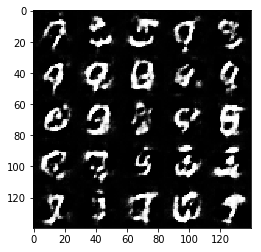

Epoch 2/2... Discriminator Loss: 0.2975... Generator Loss: 2.6064
Epoch 2/2... Discriminator Loss: 0.2353... Generator Loss: 2.4084
Epoch 2/2... Discriminator Loss: 0.3305... Generator Loss: 1.6778
Epoch 2/2... Discriminator Loss: 0.3284... Generator Loss: 1.7846
Epoch 2/2... Discriminator Loss: 0.2849... Generator Loss: 2.3543
Epoch 2/2... Discriminator Loss: 0.1933... Generator Loss: 2.7851
Epoch 2/2... Discriminator Loss: 0.2393... Generator Loss: 2.4230
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 1.0895
Epoch 2/2... Discriminator Loss: 0.1824... Generator Loss: 2.5395
Epoch 2/2... Discriminator Loss: 0.1702... Generator Loss: 3.2269


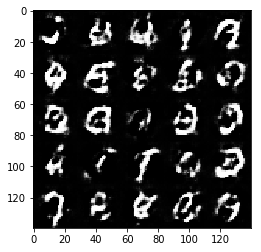

Epoch 2/2... Discriminator Loss: 0.1922... Generator Loss: 2.4318
Epoch 2/2... Discriminator Loss: 0.2270... Generator Loss: 2.2527
Epoch 2/2... Discriminator Loss: 0.2243... Generator Loss: 2.6303
Epoch 2/2... Discriminator Loss: 0.2136... Generator Loss: 2.6711
Epoch 2/2... Discriminator Loss: 0.2054... Generator Loss: 2.3152
Epoch 2/2... Discriminator Loss: 0.1467... Generator Loss: 3.1772
Epoch 2/2... Discriminator Loss: 0.1243... Generator Loss: 3.0909
Epoch 2/2... Discriminator Loss: 0.2971... Generator Loss: 2.4903
Epoch 2/2... Discriminator Loss: 0.2702... Generator Loss: 3.0149
Epoch 2/2... Discriminator Loss: 0.2142... Generator Loss: 2.6643


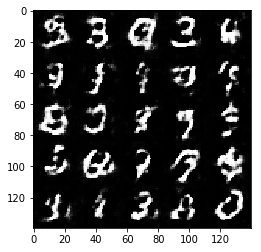

Epoch 2/2... Discriminator Loss: 0.2633... Generator Loss: 2.3813
Epoch 2/2... Discriminator Loss: 0.2269... Generator Loss: 2.4481
Epoch 2/2... Discriminator Loss: 0.3747... Generator Loss: 1.7660
Epoch 2/2... Discriminator Loss: 0.3188... Generator Loss: 2.2120
Epoch 2/2... Discriminator Loss: 0.3642... Generator Loss: 1.8071
Epoch 2/2... Discriminator Loss: 0.1652... Generator Loss: 3.2403
Epoch 2/2... Discriminator Loss: 0.2639... Generator Loss: 2.6425
Epoch 2/2... Discriminator Loss: 0.1689... Generator Loss: 2.7022
Epoch 2/2... Discriminator Loss: 0.4825... Generator Loss: 1.5294
Epoch 2/2... Discriminator Loss: 0.3236... Generator Loss: 1.9826


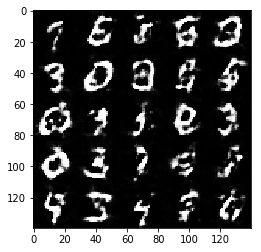

Epoch 2/2... Discriminator Loss: 0.2317... Generator Loss: 2.2489
Epoch 2/2... Discriminator Loss: 0.2797... Generator Loss: 2.5604
Epoch 2/2... Discriminator Loss: 0.2298... Generator Loss: 2.6754
Epoch 2/2... Discriminator Loss: 0.2186... Generator Loss: 2.6133
Epoch 2/2... Discriminator Loss: 0.2798... Generator Loss: 3.2323
Epoch 2/2... Discriminator Loss: 0.1617... Generator Loss: 2.6786
Epoch 2/2... Discriminator Loss: 0.2679... Generator Loss: 3.0796
Epoch 2/2... Discriminator Loss: 0.2361... Generator Loss: 2.9564
Epoch 2/2... Discriminator Loss: 0.1759... Generator Loss: 2.7666
Epoch 2/2... Discriminator Loss: 0.2592... Generator Loss: 2.7059


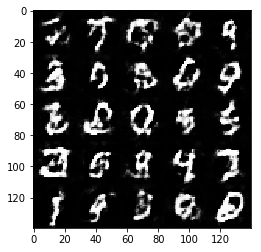

Epoch 2/2... Discriminator Loss: 0.2908... Generator Loss: 2.0539
Epoch 2/2... Discriminator Loss: 0.3276... Generator Loss: 2.0192
Epoch 2/2... Discriminator Loss: 0.2858... Generator Loss: 2.6828
Epoch 2/2... Discriminator Loss: 0.2125... Generator Loss: 3.0436
Epoch 2/2... Discriminator Loss: 0.3634... Generator Loss: 1.6610
Epoch 2/2... Discriminator Loss: 0.4326... Generator Loss: 1.5185
Epoch 2/2... Discriminator Loss: 0.2776... Generator Loss: 2.4703
Epoch 2/2... Discriminator Loss: 0.2209... Generator Loss: 2.4302
Epoch 2/2... Discriminator Loss: 0.3322... Generator Loss: 1.7967
Epoch 2/2... Discriminator Loss: 0.2492... Generator Loss: 2.0285


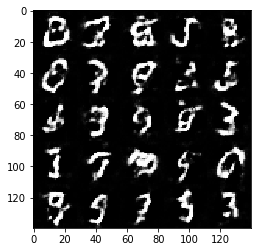

Epoch 2/2... Discriminator Loss: 0.2590... Generator Loss: 2.1857
Epoch 2/2... Discriminator Loss: 0.2025... Generator Loss: 2.9359
Epoch 2/2... Discriminator Loss: 0.2537... Generator Loss: 2.0637
Epoch 2/2... Discriminator Loss: 0.3290... Generator Loss: 1.9961
Epoch 2/2... Discriminator Loss: 0.2704... Generator Loss: 2.2785
Epoch 2/2... Discriminator Loss: 0.3874... Generator Loss: 2.8569
Epoch 2/2... Discriminator Loss: 0.2624... Generator Loss: 2.3792
Epoch 2/2... Discriminator Loss: 0.6841... Generator Loss: 1.1238
Epoch 2/2... Discriminator Loss: 0.2501... Generator Loss: 2.4219
Epoch 2/2... Discriminator Loss: 0.3186... Generator Loss: 1.9161


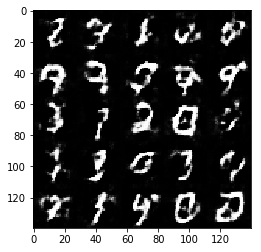

Epoch 2/2... Discriminator Loss: 0.3137... Generator Loss: 2.7625
Epoch 2/2... Discriminator Loss: 0.2583... Generator Loss: 2.2621
Epoch 2/2... Discriminator Loss: 0.2664... Generator Loss: 3.1757
Epoch 2/2... Discriminator Loss: 0.2624... Generator Loss: 2.8757
Epoch 2/2... Discriminator Loss: 0.2786... Generator Loss: 2.2024
Epoch 2/2... Discriminator Loss: 0.3094... Generator Loss: 2.0064
Epoch 2/2... Discriminator Loss: 0.2315... Generator Loss: 2.7796
Epoch 2/2... Discriminator Loss: 0.3213... Generator Loss: 1.9267
Epoch 2/2... Discriminator Loss: 0.4007... Generator Loss: 1.5899
Epoch 2/2... Discriminator Loss: 0.1666... Generator Loss: 2.5939


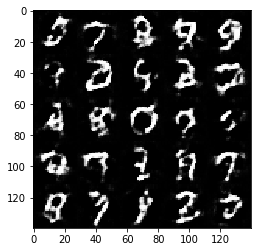

Epoch 2/2... Discriminator Loss: 0.2658... Generator Loss: 2.5131
Epoch 2/2... Discriminator Loss: 0.3943... Generator Loss: 1.5195
Epoch 2/2... Discriminator Loss: 0.4798... Generator Loss: 1.4357
Epoch 2/2... Discriminator Loss: 0.3561... Generator Loss: 2.1001
Epoch 2/2... Discriminator Loss: 0.2428... Generator Loss: 2.3912
Epoch 2/2... Discriminator Loss: 0.6224... Generator Loss: 1.2253
Epoch 2/2... Discriminator Loss: 0.3549... Generator Loss: 2.3917
Epoch 2/2... Discriminator Loss: 0.2474... Generator Loss: 2.6286
Epoch 2/2... Discriminator Loss: 0.2434... Generator Loss: 2.3329
Epoch 2/2... Discriminator Loss: 0.2247... Generator Loss: 2.5268


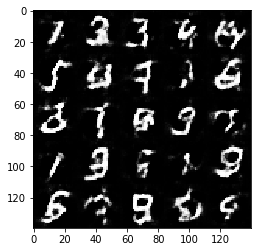

Epoch 2/2... Discriminator Loss: 0.3090... Generator Loss: 2.2693
Epoch 2/2... Discriminator Loss: 0.2171... Generator Loss: 2.3522
Epoch 2/2... Discriminator Loss: 0.3276... Generator Loss: 1.9126
Epoch 2/2... Discriminator Loss: 0.2397... Generator Loss: 2.5400
Epoch 2/2... Discriminator Loss: 0.4555... Generator Loss: 1.4352
Epoch 2/2... Discriminator Loss: 0.3255... Generator Loss: 1.9530
Epoch 2/2... Discriminator Loss: 0.3133... Generator Loss: 2.4319
Epoch 2/2... Discriminator Loss: 0.1820... Generator Loss: 2.5924
Epoch 2/2... Discriminator Loss: 0.2206... Generator Loss: 3.1613
Epoch 2/2... Discriminator Loss: 0.1629... Generator Loss: 3.4485


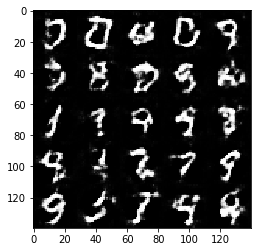

Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 2.6615
Epoch 2/2... Discriminator Loss: 0.2577... Generator Loss: 2.6863
Epoch 2/2... Discriminator Loss: 0.2049... Generator Loss: 2.4513
Epoch 2/2... Discriminator Loss: 0.4484... Generator Loss: 1.5535
Epoch 2/2... Discriminator Loss: 0.2714... Generator Loss: 2.5229
Epoch 2/2... Discriminator Loss: 0.2930... Generator Loss: 2.2859
Epoch 2/2... Discriminator Loss: 0.2993... Generator Loss: 2.7090
Epoch 2/2... Discriminator Loss: 0.5848... Generator Loss: 1.1954
Epoch 2/2... Discriminator Loss: 0.4964... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.2220... Generator Loss: 2.4891


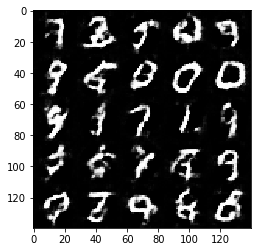

Epoch 2/2... Discriminator Loss: 0.3213... Generator Loss: 1.9901
Epoch 2/2... Discriminator Loss: 0.3729... Generator Loss: 2.4919
Epoch 2/2... Discriminator Loss: 0.2174... Generator Loss: 2.6308
Epoch 2/2... Discriminator Loss: 0.6188... Generator Loss: 1.1656
Epoch 2/2... Discriminator Loss: 0.3374... Generator Loss: 2.1583
Epoch 2/2... Discriminator Loss: 0.3609... Generator Loss: 2.0795
Epoch 2/2... Discriminator Loss: 0.3389... Generator Loss: 2.5078
Epoch 2/2... Discriminator Loss: 0.2498... Generator Loss: 2.3905
Epoch 2/2... Discriminator Loss: 0.2520... Generator Loss: 2.1870
Epoch 2/2... Discriminator Loss: 0.3494... Generator Loss: 2.5472


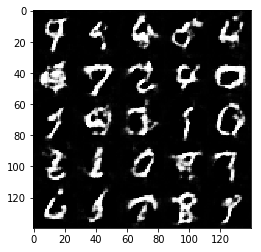

Epoch 2/2... Discriminator Loss: 0.2266... Generator Loss: 2.2460
Epoch 2/2... Discriminator Loss: 0.6685... Generator Loss: 2.3175
Epoch 2/2... Discriminator Loss: 0.3822... Generator Loss: 1.7181
Epoch 2/2... Discriminator Loss: 0.2640... Generator Loss: 2.5643
Epoch 2/2... Discriminator Loss: 0.4445... Generator Loss: 1.4937
Epoch 2/2... Discriminator Loss: 0.2712... Generator Loss: 1.9770
Epoch 2/2... Discriminator Loss: 0.4962... Generator Loss: 2.4974
Epoch 2/2... Discriminator Loss: 0.3494... Generator Loss: 1.7061
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 1.6912
Epoch 2/2... Discriminator Loss: 0.4127... Generator Loss: 2.0552


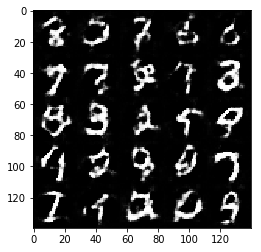

Epoch 2/2... Discriminator Loss: 0.3034... Generator Loss: 3.0380
Epoch 2/2... Discriminator Loss: 0.2428... Generator Loss: 2.8489
Epoch 2/2... Discriminator Loss: 0.4795... Generator Loss: 1.4840
Epoch 2/2... Discriminator Loss: 0.1747... Generator Loss: 2.6697
Epoch 2/2... Discriminator Loss: 0.4177... Generator Loss: 1.5332
Epoch 2/2... Discriminator Loss: 0.3653... Generator Loss: 2.0306
Epoch 2/2... Discriminator Loss: 0.3861... Generator Loss: 1.6409
Epoch 2/2... Discriminator Loss: 0.2801... Generator Loss: 2.3657
Epoch 2/2... Discriminator Loss: 0.3402... Generator Loss: 2.5717
Epoch 2/2... Discriminator Loss: 0.3628... Generator Loss: 2.4687


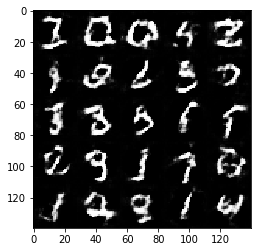

Epoch 2/2... Discriminator Loss: 0.3893... Generator Loss: 1.7123
Epoch 2/2... Discriminator Loss: 0.4785... Generator Loss: 1.5964
Epoch 2/2... Discriminator Loss: 0.3387... Generator Loss: 1.8723
Epoch 2/2... Discriminator Loss: 0.3019... Generator Loss: 2.4038
Epoch 2/2... Discriminator Loss: 0.5153... Generator Loss: 1.9316
Epoch 2/2... Discriminator Loss: 0.3660... Generator Loss: 2.4076
Epoch 2/2... Discriminator Loss: 0.3366... Generator Loss: 1.9918
Epoch 2/2... Discriminator Loss: 0.3760... Generator Loss: 2.6033
Epoch 2/2... Discriminator Loss: 0.6738... Generator Loss: 1.1797
Epoch 2/2... Discriminator Loss: 0.4397... Generator Loss: 2.8387


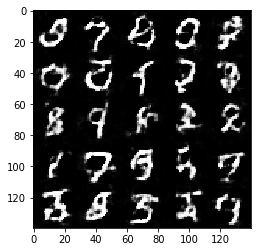

Epoch 2/2... Discriminator Loss: 0.3212... Generator Loss: 2.5137
Epoch 2/2... Discriminator Loss: 0.4696... Generator Loss: 1.5123
Epoch 2/2... Discriminator Loss: 0.3392... Generator Loss: 2.1856
Epoch 2/2... Discriminator Loss: 0.5124... Generator Loss: 1.4319
Epoch 2/2... Discriminator Loss: 0.3760... Generator Loss: 2.3789


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.00002
beta1 = 0.5
alpha= 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 2.9507
Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 5.6624
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 3.3455
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 3.9658
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 5.8697
Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 1.9237
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.8835... Generator Loss: 6.1719


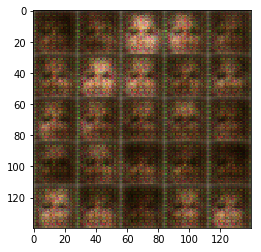

Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 2.4663
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.4113
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 2.1923
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.8766
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 2.0970


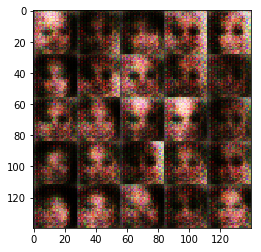

Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 1.7863
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 2.6059
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 2.2261
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 2.9313
Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 2.5429
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.6125
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.6104


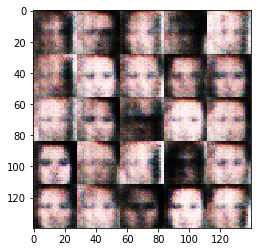

Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.8215
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 2.5827
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.6980
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.8533
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 3.5731
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.8465
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.5287
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.2799


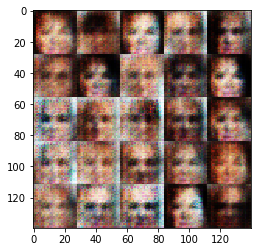

Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 2.0214
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 3.4151
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 2.8577
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 2.3838
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 2.0347


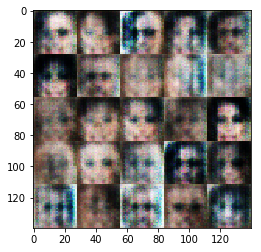

Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 1.4749
Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 1.6388
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 1.7635
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 2.3382
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.6259


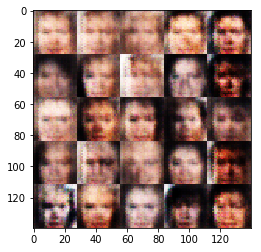

Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.6797
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 2.3104
Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 2.7219
Epoch 1/1... Discriminator Loss: 0.7783... Generator Loss: 1.9193
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.8548
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 2.2942


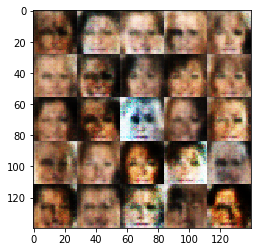

Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 1.5895
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 2.1532
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 2.0744
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.7268
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.8554


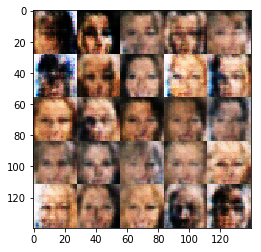

Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.6741
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.4981
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 1.9385
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.7064
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.2971


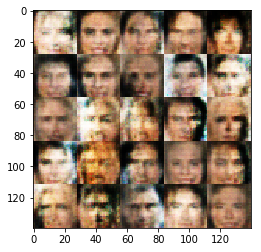

Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.5791
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.6878
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.5140
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.2567
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.8826


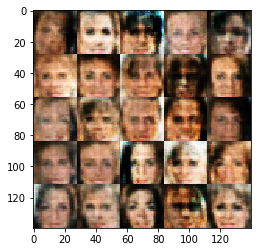

Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.7992
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.5555
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.3140
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.5500
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 1.2583
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.0540


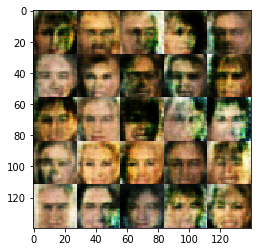

Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.9468
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.7983
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.2897
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.9920


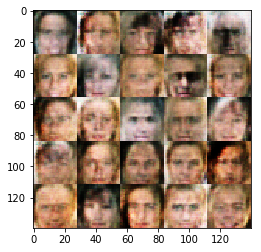

Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.8810
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.7325
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.4911
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.7754
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.3425
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 2.3435


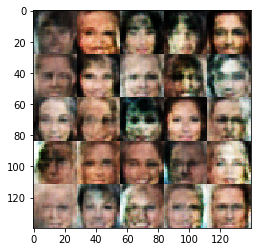

Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.7794
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.5592
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.9539


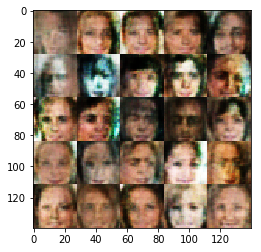

Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 2.0229
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.3695
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 1.5594
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.3580


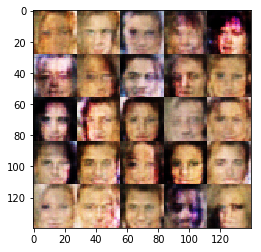

Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.1723
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.5016
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.5508
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 0.8218... Generator Loss: 1.5945
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.1882


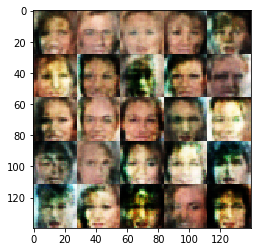

Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.4032
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 2.0969
Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 1.6108
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.8104


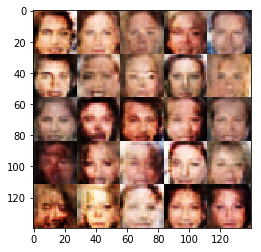

Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 2.1986
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.5543
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 1.8557
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.4017
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.4236
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.9239


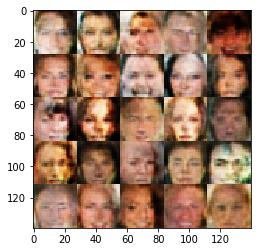

Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.4672
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.4966
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.2652
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.1870
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.5102


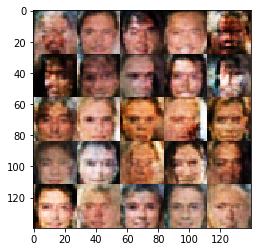

Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.7380
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.8897
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.5995
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.6681
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.0162


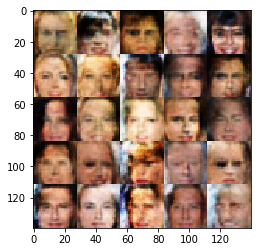

Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.2638
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 1.7595
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.4701


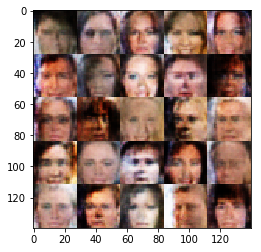

Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.2012
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.6686
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.7842
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.5036


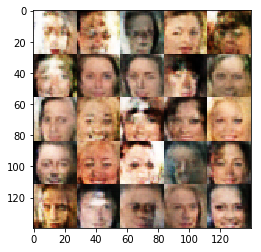

Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.1264
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.9224


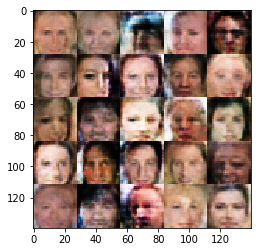

Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.7955
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.3376
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 1.4971
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.3954


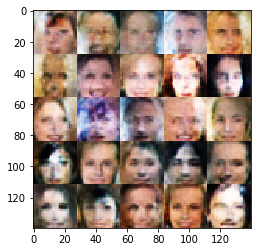

Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.6253
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 2.4849
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.5979
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.6257
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.3773
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.2785


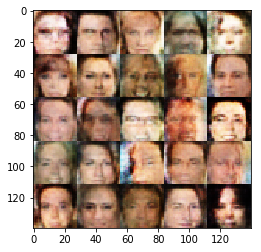

Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.8173
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.6827
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.4709
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.6076
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 1.4977


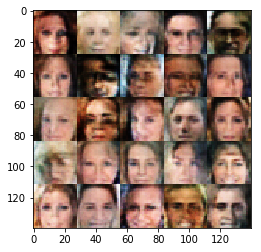

Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.4348
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.4902
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.4520
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.4432
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 1.4308
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.4464
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.1649


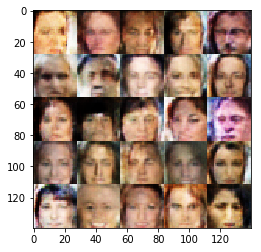

Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 1.4101
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.6895
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.8555


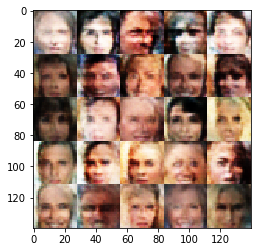

Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.9267
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.8245
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.1113


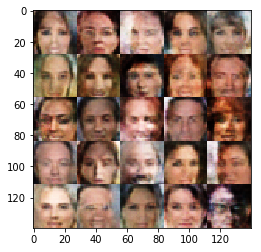

Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.6457
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 1.7376
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.3543


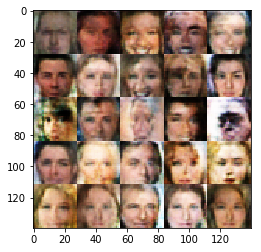

Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 2.0926
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 1.6628
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.2065
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.2642
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.5201


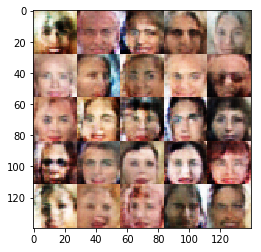

Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.8486
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.4755
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 1.8244
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.0774


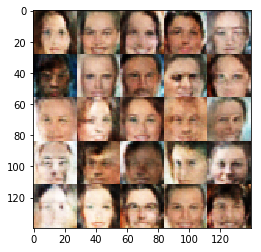

Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.3946
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.0236


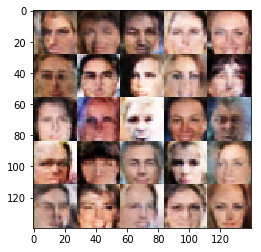

Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.6551
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.2866
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.3168


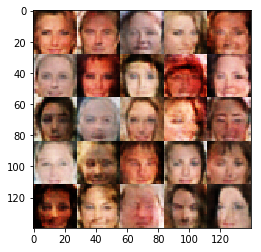

Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.2952
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.4012
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 2.0145
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.8348
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 0.8696... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.8003


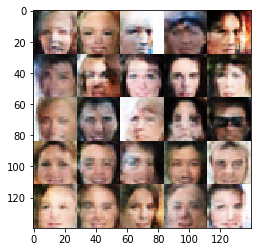

Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.7694
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.5718
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.2994


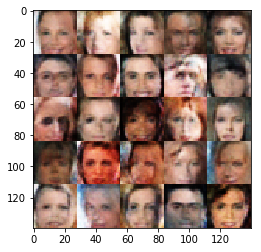

Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.6112
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.9795
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.7260
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 1.5002
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.4132


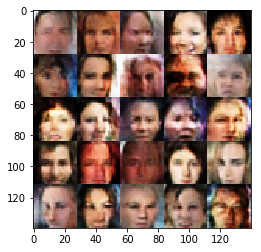

Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.1462
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.9831
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.7696
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.7503


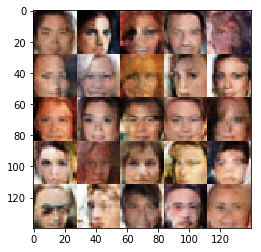

Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 1.6894
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.8702


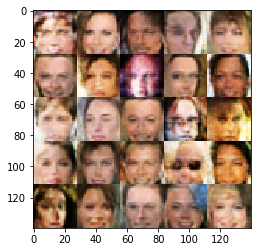

Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.2934
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.5554
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.4443
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.3221


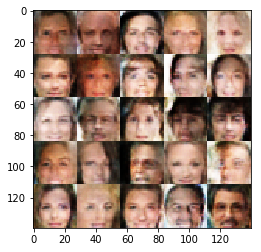

Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 1.6562
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.7131
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 1.3730
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 1.6446
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.8180


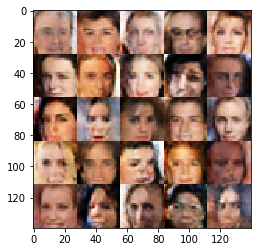

Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.3572
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6815


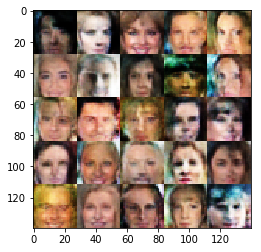

Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.2337
Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 1.7412
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.4477
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.1845
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.1533


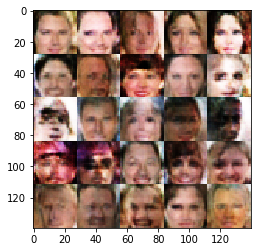

Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.5409
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.2633
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 0.9166


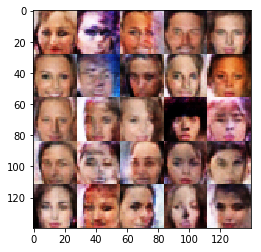

Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 0.9831
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.6302


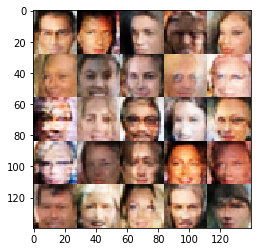

Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.6807
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.4524
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.2237


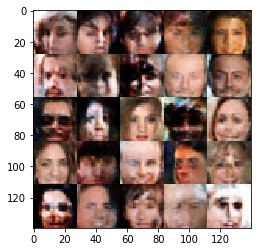

Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.4565
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.3911
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 2.0318
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.7617


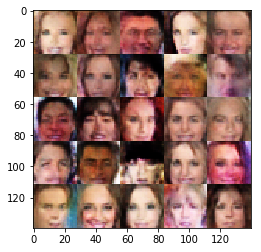

Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.3132
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 1.3756
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.5340


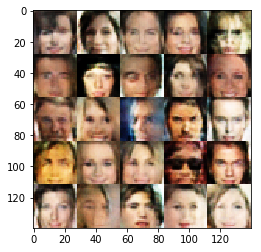

Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 2.0910
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.7276


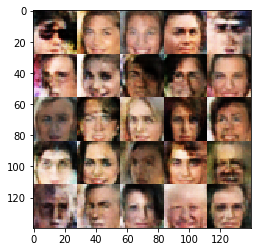

Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.3572
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.4191
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.6378
Epoch 1/1... Discriminator Loss: 1.6727... Generator Loss: 0.4444


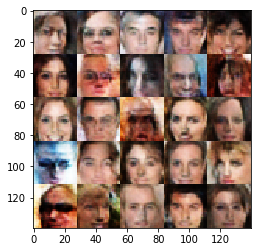

Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.2764
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.9223


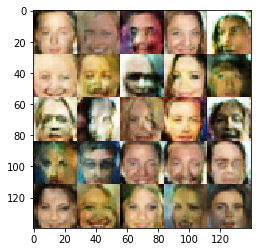

Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.3191
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.4090
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 1.6703
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.3345


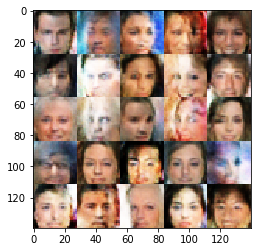

Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.1974
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.5615
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.7766


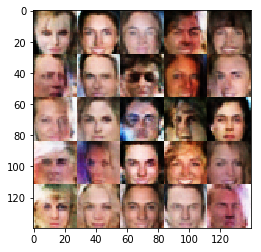

Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.5393
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.2758
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.4219
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.0328


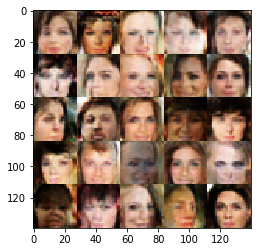

Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.5486
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.5166
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.2356


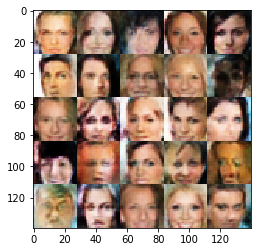

Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 2.0466
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 1.5254
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 1.1945


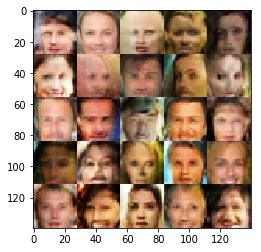

Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 1.3873
Epoch 1/1... Discriminator Loss: 0.8291... Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.7774
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.4315


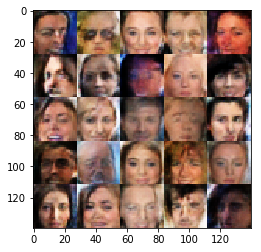

Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.5022
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 0.9721


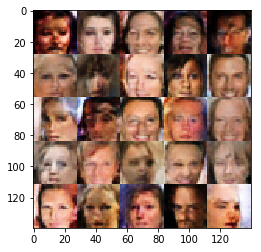

Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.7573
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.4334


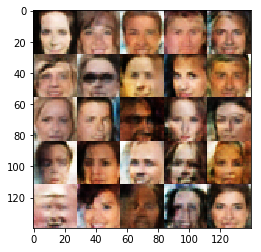

Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.1769
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.0600
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.5425


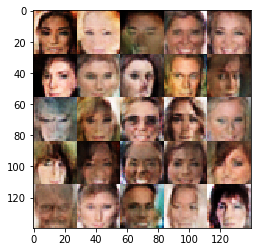

Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 1.2727


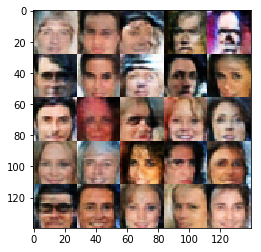

Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.6743... Generator Loss: 1.9739
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.4365
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.8606


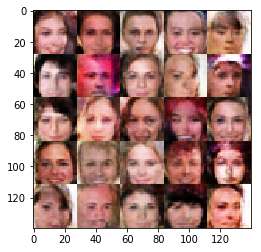

Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.7405
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.4287
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 1.2340
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.1781


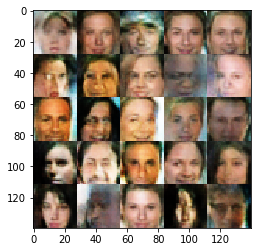

Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 0.7223... Generator Loss: 1.5664
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.4728


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha= 0.2



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.